##### Master Degree in Computer Science and Data Science for Economics

# Tiny BERT

### Alfio Ferrara

Toy implementation of BERT (Bidirectional Encoder Representations from Transformers).

<u>Acknowledgment of AI Assistance.</u>
*This notebook was prepared with the support of Google's Gemini model. Its role was assistive, providing code scaffolding and conceptual brainstorming. The author has subsequently reviewed, curated, and validated all content, and assumes full responsibility for its final accuracy and all errors.*

## 1. Introduction to BERT

BERT stands for Bidirectional Encoder Representations from Transformers. It's a language representation model that was a major breakthrough in NLP because it was the first to be deeply bidirectional.

Unlike previous models that read text either left-to-right (like GPT) or combined separate left-to-right and right-to-left passes, BERT's core architecture reads the entire sequence at once, allowing every word to "see" every other word in both directions.

With respect to the Transformers architecture, BERT uses only the **Encoder** stack. Therefore, the goal is not to generate a text but to *understand* a text, i.e., to provide a semantically rich vector representation of a text.

#### Architecture
- **Embedding**
    - **Token Embedding**: vector representation of each token meaning
    - **Positional Embedding**: a vector representation of the position of each token (that is learned in BERT)
- **Multi-Head Self-Attention**: attention mechanism used to learn the mutual relevance of tokens within a sequence
- **Feed-Formard Network**
- **Residual connections** and **Layer normalization** procedures

#### Special tokens
Since BERT is trained to work with two sentences and in some cases the goal is to understand the meaning of the whole sequence, two special tokens are introduced:
- `[SEP]`: use to instruct the model on where the first sentence ends and where the second sentence starts.
- `[CLS]`: special token that will be used to rapresent the meaning of the **whole sequence**. Since, during training, this token will be used for performing the task at hand when it is necessary to work with the meaning of the whole sentences, the model learns to encode in `[CLS]` overall meaning of the entire sentence.

#### Bidirectionality and training tasks
The idea of BERT is to **look at all the tokens at the same time**, not left-to-right and then right-to-left. However, this is not compatible with the task of predicting the next token. For this reason, BERT is pre-trained in a semi-supervised manner on to tasks:
1. **Masked Language Model (MLM)**: from a corpus of real sentences, some words per sentence are masked with a special token. Then BERT is trained to predict the masked token. Example: `i'm tired! today was a [MASK] day`.
2. **Next Sentence Prediction (NSP)**: the model is trained with a dataset composed by pair of sentences `A` and `B`. In half of the pairs, `B` is the actual next sentence of `A` in a real document. In the other half, `B` is just a random sentence taken from the corpus. The goal of BERT is to predict whether a sentence `B` is the next sentence with respect to a previous sentence `A`.
Note that both the tasks are base on typical exercises that we humans also do when we **read and understand a text**, now during writing.

By training on both MLM and NSP simultaneously, BERT learns rich word-level and sentence-level representations. This pre-trained model can then be fine-tuned on specific tasks (like sentiment analysis or question answering) with very little task-specific architecture.

## 2. Our toy example of data and tasks
We will use a custom "Daily Emoji" corpus, which consists of several short "stories" about a person's day, represented by emoji sequences.

### 1. The Vocabulary ($V = 14$)

Our model will only know 14 "words" in total. The vocabulary is split into two categories:

* **Special Tokens (5):** These are required by the BERT architecture.
    * `[PAD]`: (ID 0) For padding sequences to a fixed length.
    * `[UNK]`: (ID 1) For any token not in our vocabulary.
    * `[CLS]`: (ID 2) The "Classification" token. Its final embedding will be used for the NSP task.
    * `[SEP]`: (ID 3) The "Separator" token, used to delimit sentences.
    * `[MASK]`: (ID 4) The token we will ask the model to predict in the MLM task.
* **Emoji Tokens (9):** These are our "words."
    * `☀️`: Morning
    * `🌙`: Night
    * `🧑`: Person
    * `☕`: Coffee
    * `🥐`: Croissant/Food
    * `💻`: Work/Laptop
    * `🏃`: Run
    * `📖`: Read
    * `😴`: Sleep

### 2. The Corpus (The "Stories")

Our corpus is a collection of small documents (stories). Each document is a list of logical, chronological "sentences" (emoji sequences).

**Document 1: "The Morning Routine"**
* Sentence 1: `☀️ 🧑 🏃`
* Sentence 2: `🧑 ☕ 🥐`
* Sentence 3: `🧑 💻`

**Document 2: "The Evening Routine"**
* Sentence 1: `🌙 🧑 📖`
* Sentence 2: `🧑 😴`

**Document 3: "The Other Morning"**
* Sentence 1: `☀️ 🧑 ☕`
* Sentence 2: `🧑 💻`

### 3. The Pre-Training Tasks

We will pre-train our Tiny BERT on this corpus using the two famous, self-supervised tasks.

#### 1. Task 1: Masked Language Model (MLM)

* **The Goal:** To predict a randomly hidden token. This forces the model to learn relationships *between* tokens in a sequence.
* **Example:**
    * **Raw Sentence:** `🧑 ☕ 🥐`
    * **BERT Input:** `[CLS] 🧑 ☕ [MASK] [SEP]`
    * **Target Label:** `🥐`
    * **What it learns:** The model must look at `🧑` and `☕` to understand that `🥐` is the most logical token to fill the blank. It learns the association: "person + coffee $\rightarrow$ food."

#### 2. Task 2: Next Sentence Prediction (NSP)

* **The Goal:** To understand the relationship *between* two sentences. This teaches the model sequence-level coherence. This task uses the special `[CLS]` token's final output.
* **How it works:** We feed the model two sentences (A and B) concatenated into a single sequence. 50% of the time, B will be the *actual* next sentence from the corpus. 50% of the time, it will be a random sentence.

**Example 1: A `True` Pair (`IsNext`)**

* **Sentence A (Raw):** `☀️ 🧑 🏃`
* **Sentence B (Raw):** `🧑 ☕ 🥐`
* **BERT Input Sequence:** `[CLS] ☀️ 🧑 🏃 [SEP] 🧑 ☕ 🥐 [SEP]`
* **Segment IDs:** `0 0 0 0 0 1 1 1 1 1`
* **Target Label:** `IsNext`
* **What it learns:** The model learns that breakfast (`🧑 ☕ 🥐`) logically follows a morning run (`☀️ 🧑 🏃`).

**Example 2: A `False` Pair (`NotNext`)**

* **Sentence A (Raw):** `☀️ 🧑 🏃`
* **Sentence B (Raw):** `🧑 😴`
* **BERT Input Sequence:** `[CLS] ☀️ 🧑 🏃 [SEP] 🧑 😴 [SEP]`
* **Segment IDs:** `0 0 0 0 0 1 1 1 1`
* **Target Label:** `NotNext`
* **What it learns:** The model learns that "sleeping" (`🧑 😴`) is not the logical next step after a "morning run" (`☀️ 🧑 🏃`).

## 3. Embedding
In our simple example we are going to use a simple tokenizer that just splits the text by whitespace. Then we need a map between tokens and numerical IDs.

In [1]:
import torch
import torch.nn as nn
import math

config = {
    "vocab_size": 14,                # V: 5 special + 9 emojis
    "hidden_size": 8,                # d_model: The main vector size
    "max_position_embeddings": 16,   # max_len: Longest possible sequence
    "type_vocab_size": 2,            # 0 for Sentence A, 1 for Sentence B
    "hidden_dropout_prob": 0.1       # Standard BERT dropout
}

TOKEN_TO_ID = {
    '[PAD]': 0,
    '[UNK]': 1,
    '[CLS]': 2,
    '[SEP]': 3,
    '[MASK]': 4,
    '☀️': 5,
    '🌙': 6,
    '🧑': 7,
    '☕': 8,
    '🥐': 9,
    '💻': 10,
    '🏃': 11,
    '📖': 12,
    '😴': 13,
}

ID_TO_TOKEN = {id: token for token, id in TOKEN_TO_ID.items()}
TOKEN_TO_TEXT = {
    '[PAD]': '[PAD]',
    '[UNK]': '[UNK]',
    '[CLS]': '[CLS]',
    '[SEP]': '[SEP]',
    '[MASK]': '[MASK]',
    '☀️': 'day',
    '🌙': 'night',
    '🧑': 'person',
    '☕': 'coffee',
    '🥐': 'food',
    '💻':'work',
    '🏃': 'run',
    '📖': 'book',
    '😴': 'sleep',
}

def tokenize(sentence, vocab_map):
    """Converts a string of emojis into a list of token IDs."""
    tokens = sentence.split(' ')
    return [vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]

def create_segment_ids(token_ids, sep_id):
    """
    Generates the list of segment IDs (0s and 1s) from a list of token IDs.
    All tokens *before and including* the first [SEP] are segment 0.
    All tokens *after* the first [SEP] are segment 1.
    """
    segment_ids = []
    current_segment = 0
    for token_id in token_ids:
        segment_ids.append(current_segment)
        # If this is the first [SEP] token, flip to segment 1
        if token_id == sep_id and current_segment == 0:
            current_segment = 1
    return segment_ids

**Example of tokenization**

In [2]:
sentence_a = "☀️ 🧑 🏃"
sentence_b = "🧑 ☕ 🥐"

print("TOKENIZATION")

print("Tokens to IDs")
print(f"First sentence: {tokenize(sentence_a, TOKEN_TO_ID)}")
print(f"Second sentence: {tokenize(sentence_b, TOKEN_TO_ID)}")

bert_real_input = f"[CLS] {sentence_a} [SEP] {sentence_b} [SEP]"

print("BERT real input")
print(bert_real_input)
tokens = tokenize(bert_real_input, TOKEN_TO_ID)
print(f"Full tokens to IDs: {tokens}")
token_type_ids = create_segment_ids(tokens, sep_id=TOKEN_TO_ID['[SEP]'])
print(f"Token types: {token_type_ids}")

TOKENIZATION
Tokens to IDs
First sentence: [5, 7, 11]
Second sentence: [7, 8, 9]
BERT real input
[CLS] ☀️ 🧑 🏃 [SEP] 🧑 ☕ 🥐 [SEP]
Full tokens to IDs: [2, 5, 7, 11, 3, 7, 8, 9, 3]
Token types: [0, 0, 0, 0, 0, 1, 1, 1, 1]


In [3]:
class BertEmbeddings(nn.Module):
    """
    Constructs the BERT input embeddings.
    
    BERT Embeddings are the sum of:
    1. Token Embeddings (Word Embeddings)
    2. Position Embeddings
    3. Segment Embeddings (Token Type Embeddings) to check if a 
    token is in the first or second segment
    """
    def __init__(self, config):
        super().__init__()
        
        # 1. Token Embeddings
        # A lookup table for our 14-token vocabulary.
        # padding_idx=0 tells nn.Embedding to treat token ID 0 as "padding".
        # Its vector will be all zeros and will not be updated during training.
        self.word_embeddings = nn.Embedding(
            config["vocab_size"], 
            config["hidden_size"], 
            padding_idx=0
        )
        
        # 2. Position Embeddings
        # A lookup table for all possible positions (0 to 15).
        # This is a learned representation of *where* a token is.
        self.position_embeddings = nn.Embedding(
            config["max_position_embeddings"], 
            config["hidden_size"]
        )
        
        # 3. Segment (Token Type) Embeddings
        # A lookup table for the sentence type (0 or 1).
        # This is how the model distinguishes Sentence A from Sentence B.
        self.token_type_embeddings = nn.Embedding(
            config["type_vocab_size"], 
            config["hidden_size"]
        )
        
        # --- Post-processing ---
        # We apply Layer Normalization and Dropout *after* summing.
        # This is a standard part of the BERT architecture.
        # LayerNorm stabilizes the values, dropout prevents overfitting.
        # eps=1e-12 is from the paper. we use 1e-5
        self.LayerNorm = nn.LayerNorm(config["hidden_size"], eps=1e-5)
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, input_ids, token_type_ids):
        """
        Forward pass for the embeddings.
        
        Args:
            input_ids (torch.Tensor): Shape (batch_size, seq_length). 
                                      The token IDs.
            token_type_ids (torch.Tensor): Shape (batch_size, seq_length). 
                                           The segment IDs (0s and 1s).
        
        Returns:
            torch.Tensor: Shape (batch_size, seq_length, hidden_size).
                          The final input embeddings.
        """
        # --- 1. Get Token Embeddings ---
        # input_ids shape: (batch_size, seq_len)
        # words_embeddings shape: (batch_size, seq_len, hidden_size)
        words_embeddings = self.word_embeddings(input_ids)
        
        # --- 2. Get Segment Embeddings ---
        # token_type_ids shape: (batch_size, seq_len)
        # token_type_embeddings shape: (batch_size, seq_len, hidden_size)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)
        
        # --- 3. Get Position Embeddings ---
        # We need to create the position IDs on the fly.
        # If input_ids is (batch, 9), we need position_ids (batch, 9)
        # that looks like [[0, 1, 2, 3, 4, 5, 6, 7, 8]]
        
        # Get the sequence length: e.g., 9
        seq_length = input_ids.size(1) 
        
        # Create a tensor of [0, 1, 2, ..., seq_length-1]
        # shape: (seq_length)
        position_ids = torch.arange(
            seq_length, 
            dtype=torch.long, 
            device=input_ids.device
        )
        
        # Make it (1, seq_length) and expand it to match the batch size
        # shape: (batch_size, seq_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        
        # Look up the position embeddings
        # shape: (batch_size, seq_len, hidden_size)
        position_embeddings = self.position_embeddings(position_ids)
        
        # --- Create the final embeddings ---
        # Add all three embedding vectors together element-wise.
        embeddings = words_embeddings + position_embeddings + token_type_embeddings
        
        # --- Post-processing ---
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        
        return embeddings

**Example**

Let's suppose to work with this two sentences:
- ☀️ 🧑 🏃
- 🧑 ☕ 🥐 🏃 ☕

In [4]:
sentence_a = "☀️ 🧑 🏃"
sentence_b = "🧑 ☕ 🥐 🏃 ☕"

input_string = f"[CLS] {sentence_a} [SEP] {sentence_b} [SEP]"
print(f"Input string: {input_string}")

token_ids = tokenize(input_string, TOKEN_TO_ID)
# Convert to a PyTorch tensor (batch_size = 1)
# shape: (1, 9)
input_ids = torch.tensor([token_ids])

print(f"Input IDs:    {input_ids}")

# 3. Create the Segment IDs
token_type_ids = torch.tensor(
    create_segment_ids(token_ids, sep_id=TOKEN_TO_ID['[SEP]'])
)

print(f"Input IDs shape:        {input_ids.shape}")
print(f"Token Type IDs shape: {token_type_ids.shape}")

embedding_module = BertEmbeddings(config)
embedding_module.eval() 
with torch.no_grad():
    output_embeddings = embedding_module(input_ids, token_type_ids)

print(f"\nOutput embeddings shape: {output_embeddings.shape}")
print("\nEmbeddings\n")
print(output_embeddings[0])

Input string: [CLS] ☀️ 🧑 🏃 [SEP] 🧑 ☕ 🥐 🏃 ☕ [SEP]
Input IDs:    tensor([[ 2,  5,  7, 11,  3,  7,  8,  9, 11,  8,  3]])
Input IDs shape:        torch.Size([1, 11])
Token Type IDs shape: torch.Size([11])

Output embeddings shape: torch.Size([1, 11, 8])

Embeddings

tensor([[ 0.3880,  1.0728, -1.4493,  0.2947, -1.6721,  1.2177,  0.4069, -0.2588],
        [-1.4224, -0.4317,  0.3238, -1.3836,  0.1915,  0.5324,  0.3692,  1.8207],
        [-0.0260, -0.9036, -0.3817, -0.4431, -1.2980,  0.9840,  2.0462,  0.0222],
        [ 1.5789,  0.1803, -0.6908, -1.0786, -0.6210,  1.3988,  0.3897, -1.1574],
        [ 0.3043, -0.5622, -0.4667, -1.1249, -1.1622,  1.9165,  0.0553,  1.0399],
        [-0.1791,  0.5140, -1.0915,  0.1995,  0.4936, -1.6379,  1.8751, -0.1737],
        [-2.3398,  0.4740,  1.1898,  0.4899, -0.2257, -0.0466,  0.7225, -0.2641],
        [-1.0348,  1.6047, -1.4920,  0.9013, -0.6840, -0.4044,  0.7402,  0.3690],
        [ 0.8625,  0.2796, -0.0735, -0.4666, -1.8766, -0.8427,  0.5679,  1.5494],

#### Visualization of embedded vectors for different tokens

In [5]:
import matplotlib.pyplot as plt
import numpy as np


In [6]:
print(" ".join([f"{ID_TO_TOKEN[token]}: {i}" for i, token in enumerate(token_ids)]))
final_embedding_1 = output_embeddings[0, 2, :].detach().numpy() # Pos 2
final_embedding_2 = output_embeddings[0, 5, :].detach().numpy() # Pos 5

[CLS]: 0 ☀️: 1 🧑: 2 🏃: 3 [SEP]: 4 🧑: 5 ☕: 6 🥐: 7 🏃: 8 ☕: 9 [SEP]: 10


--- Vector for 🧑 at Position 2 ---
[-0.02596441 -0.9036341  -0.38171342 -0.44313708 -1.2980257   0.9840182
  2.0462222   0.02223461]

--- Vector for 🧑 at Position 5 ---
[-0.179137    0.5139632  -1.0914526   0.19949684  0.49359736 -1.6379064
  1.8751258  -0.1736873 ]


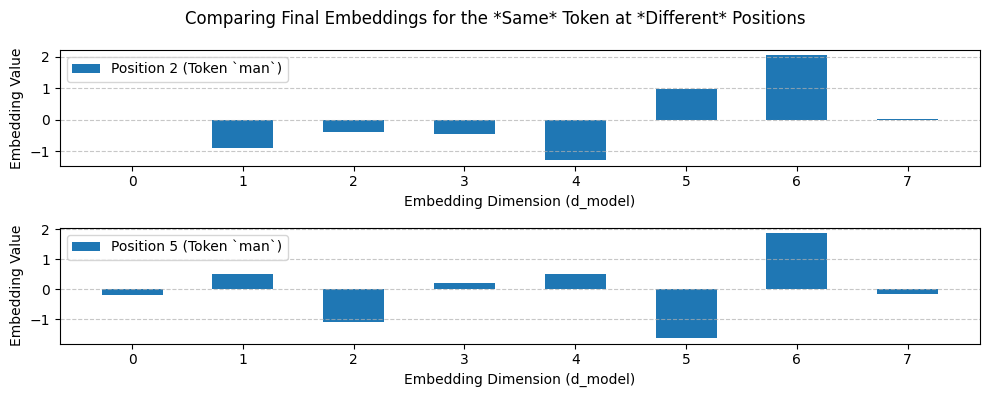

In [7]:
# Let's print them first
print(f"--- Vector for 🧑 at Position 2 ---")
print(final_embedding_1)
print(f"\n--- Vector for 🧑 at Position 5 ---")
print(final_embedding_2)

vec1 = final_embedding_1
vec2 = final_embedding_2
dims = np.arange(config["hidden_size"])
width = 0.55

fig, ax = plt.subplots(figsize=(10, 4), nrows=2)
rects1 = ax[0].bar(dims, vec1, width, label=f'Position 2 (Token `man`)')
rects2 = ax[1].bar(dims, vec2, width, label=f'Position 5 (Token `man`)')
fig.suptitle('Comparing Final Embeddings for the *Same* Token at *Different* Positions')
ax[0].set_ylabel('Embedding Value')
ax[0].set_xlabel('Embedding Dimension (d_model)')
ax[0].set_xticks(dims)
ax[0].set_xticklabels(dims)
ax[0].legend()
ax[0].grid(axis='y', linestyle='--', alpha=0.7)
ax[1].set_ylabel('Embedding Value')
ax[1].set_xlabel('Embedding Dimension (d_model)')
ax[1].set_xticks(dims)
ax[1].set_xticklabels(dims)
ax[1].legend()
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 4. Self Attention
The key idea of Attention is that for any given token (like ☕), its new representation will be a weighted average of all other tokens in the sequence. 

We learn these weights by three different "views" of the token. Ideally, the three views should represent different perspectives over the tokens:

1. Query ($Q$): "What I am looking for." (e.g., ☕ might be "looking for" 🧑 or 🥐)
2. Key ($K$): "What I am." (e.g., 🥐 might say, "I am food")
3. Value ($V$): "What I bring to the table." (The actual "content" of the 🥐 token)

The model finds the **attention weights** by matching the **Query** of one token to the **Key** of all other tokens. It's like a compatibility score. Then it uses those scores to create a weighted sum of all the **Values**.

**NOTE**: In the real BERT we have 12 multi-head attention layers running in parallel. In this tiny version, we will implement a single-head attention layer.

In [8]:
config['attention_heads'] = 1
config['attention_dropout_prob'] = 0.1

In [9]:
class SelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_attention_heads = config['attention_heads']
        self.dropout_prob = config['attention_dropout_prob']
        self.hidden_size = config['hidden_size']

        if self.hidden_size % self.num_attention_heads != 0:
            raise ValueError("The hidden size is not a multiple of the number of attention heads")

        self.attention_head_size = int(self.hidden_size / self.num_attention_heads)
        
        # In a multi-head setup, all_head_size would be (num_heads * head_size).
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        
        # --- The 3 Linear Layers ---
        # These project the input embeddings (d_model=8) into Q, K, and V.
        self.Q = nn.Linear(self.hidden_size, self.all_head_size)
        self.K = nn.Linear(self.hidden_size, self.all_head_size)
        self.V = nn.Linear(self.hidden_size, self.all_head_size)
        
        self.dropout = nn.Dropout(self.dropout_prob)

    def forward(self, hidden_states):
        """
        Args:
            hidden_states (torch.Tensor): Shape (batch_size, seq_length, hidden_size)
                                          (This is the output from our BertEmbeddings)
        
        Returns:
            context_layer (torch.Tensor): Shape (batch_size, seq_length, hidden_size)
                                          (The context-aware embeddings)
            attention_probs (torch.Tensor): Shape (batch_size, num_heads, seq_length, seq_length)
                                            (The attention weights, for visualization)
        """
        
        # 1. Project to Q, K, V
        Q = self.Q(hidden_states)
        K = self.K(hidden_states)
        V = self.V(hidden_states)
        
        # NOTE: In a *multi-head* setup, we would now split (batch, seq_len, 8)
        # into (batch, num_heads, seq_len, head_size).
        # Since num_heads=1, we can just add a "dummy" head dimension.
        # Q: (batch, 1, seq_len, 8)
        Q = Q.view(Q.size(0), Q.size(1), self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        K = K.view(K.size(0), K.size(1), self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        V = V.view(V.size(0), V.size(1), self.num_attention_heads, self.attention_head_size).transpose(1, 2)

        # 2. Calculate Attention Scores (Q @ K.T)
        attention_scores = torch.matmul(Q, K.transpose(-1, -2))
        
        # 3. Scale the scores
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        
        # 4. Apply Softmax to get probabilities
        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        
        # Apply dropout to the probabilities
        attention_probs = self.dropout(attention_probs)
        
        # 5. Get Weighted Sum of Values (Weights @ V)
        context_layer = torch.matmul(attention_probs, V)
        
        # NOTE: In a *multi-head* setup, we'd now "un-split" the heads:
        # 1. Transpose: (batch, seq_len, num_heads, head_size)
        # 2. Reshape:  (batch, seq_len, all_head_size)
        # We do it here just to be architecturally correct.
        context_layer = context_layer.transpose(1, 2).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)
        
        # We return both the final vectors and the attention weights
        return context_layer, attention_probs

**Compute Attention (Untrained)**

In [10]:
input_string = f"[CLS] {sentence_a} [SEP] {sentence_b} [SEP]"
print(input_string)
token_ids = tokenize(input_string, TOKEN_TO_ID)
input_ids = torch.tensor([token_ids])
token_type_ids = torch.tensor(
    create_segment_ids(token_ids, sep_id=TOKEN_TO_ID['[SEP]'])
)

embedding_module.eval()
with torch.no_grad():
    input_embeddings = embedding_module(input_ids, token_type_ids)

print(f"Input embeddings shape: {input_embeddings.shape}")

attention_module = SelfAttention(config=config)
attention_module.eval()
with torch.no_grad():
    context_vectors, attention = attention_module(input_embeddings)

print(f"\nContext Vectors shape:  {context_vectors.shape}")
print(f"Attention Matrix shape: {attention.shape}")

[CLS] ☀️ 🧑 🏃 [SEP] 🧑 ☕ 🥐 🏃 ☕ [SEP]
Input embeddings shape: torch.Size([1, 11, 8])

Context Vectors shape:  torch.Size([1, 11, 8])
Attention Matrix shape: torch.Size([1, 1, 11, 11])


**Visualize attention**

In [11]:
def plot_attention_heatmap(attention_matrix, token_ids, head_index=0, batch_item=0):
    matrix = attention_matrix[batch_item, head_index].to('cpu').detach().numpy()
    tokens = [TOKEN_TO_TEXT[ID_TO_TOKEN[t]] for t in token_ids]
    seq_len = len(tokens)

    fig, ax = plt.subplots(figsize=(9, 5 * attention_matrix.shape[0]))
    im = ax.imshow(matrix, cmap='Reds')

    ax.set_xticks(np.arange(seq_len))
    ax.set_yticks(np.arange(seq_len))
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)
    
    # The Y-axis is the "Query" (the token *doing* the looking)
    # The X-axis is the "Key" (the token *being* looked at)
    ax.set_ylabel("Query (Token 'looking')")
    ax.set_xlabel("Key (Token 'being looked at')")
    ax.set_title(f"Attention Weights (Head {head_index})")

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    threshold = matrix.max() * 0.6
    for i in range(seq_len):
        for j in range(seq_len):
            val = matrix[i, j]
            color = "white" if val < threshold else "black"
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=color)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    fig.tight_layout()
    plt.show()

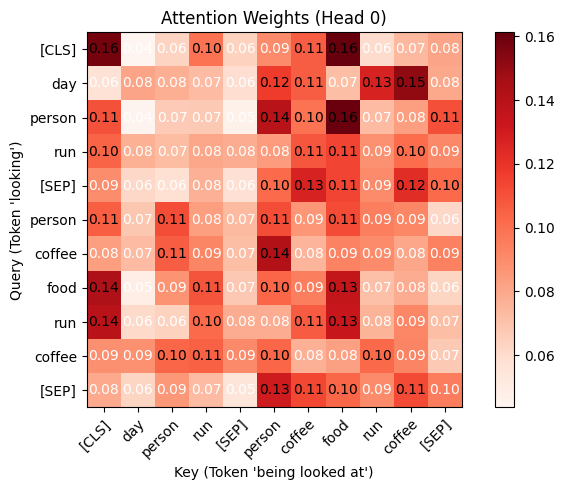

In [12]:
plot_attention_heatmap(attention_matrix=attention, token_ids=token_ids)

## 5. BERT Layer
We need to assembly all the pieces by adding some components:

1. **Add & Norm**: Adding the residual connection from the original input and normalize
2. **Feed-Formward**: A simple two-layer neural network

This module's job is to take a list of vectors, "think" about them (attention), "process" them (feed-forward), and then spit out a new, more refined list of vectors of the exact same shape.

**Why residual connection and feed-forward transformation**

1. **Residual connection** provides a "shortcut" for the original data to flow through the network. This **prevents the vanishing gradient problem**. It means that even in a very deep network, the gradients from the final loss can easily flow all the way back to the first layers via this residual direct path.

2. **FFN** add some capacity to the model:
- Non-Linearity: The operations in the attention mechanism (matrix multiplication) and the residual connection (addition) are both linear. Without the FFN and its GELU (or ReLU) activation, stacking a dozen BertLayers would just be equivalent to one giant, single linear transformation. The model couldn't learn any complex patterns. The FFN's activation function is the primary source of non-linearity that makes the "deep" in "deep learning" actually work.
- Capacity: Notice we "expand" the dimension (from 8 to 32) and then "contract" it (from 32 back to 8). This is a standard pattern. That intermediate_size of 32 gives the model a "larger workspace" to project the vector into. It can find more complex patterns in this higher-dimensional space before squashing it back down. This is also where a huge chunk of the model's parameters (and "knowledge") is stored.



In [13]:
config['intermediate_size'] = config['hidden_size'] * 4
config['hidden_act'] = 'gelu'

**BERT Self Attention complete**

In [14]:
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention_module = SelfAttention(config)
        self.dense = nn.Linear(config["hidden_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, hidden_states):
        context_vectors, attention_probs = self.attention_module(hidden_states)
        attention_output = self.dense(context_vectors)
        attention_output = self.dropout(attention_output)
        return attention_output, attention_probs

**Full Attention Layer**

In [15]:
class BertAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attention = BertSelfAttention(config)
        self.LayerNorm = nn.LayerNorm(config["hidden_size"], eps=1e-5)

    def forward(self, hidden_states):
        attention_output, attention_probs = self.self_attention(hidden_states)
        # The "Add & Norm" step:
        # 1. Add the residual (skip) connection
        # 2. Apply Layer Normalization
        # hidden_states is the *original input* to this block
        summed_output = attention_output + hidden_states
        normed_output = self.LayerNorm(summed_output)
        return normed_output, attention_probs

**Feed-forward expansion**

In [16]:
class BertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config["hidden_size"], config["intermediate_size"])
        if config["hidden_act"] == "gelu":
            self.intermediate_act_fn = nn.GELU()
        else:
            self.intermediate_act_fn = nn.ReLU()

    def forward(self, hidden_states):
        dense_output = self.dense(hidden_states)
        activated_output = self.intermediate_act_fn(dense_output)
        return activated_output

**Feed-forward contraction**

In [17]:
class BertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])
        self.LayerNorm = nn.LayerNorm(config["hidden_size"], eps=1e-5)

    def forward(self, intermediate_output, attention_output):
        dense_output = self.dense(intermediate_output)
        dropped_output = self.dropout(dense_output)
        # The *second* "Add & Norm" step
        # 1. Add the residual (from the *output* of the attention layer)
        # 2. Apply Layer Normalization
        summed_output = dropped_output + attention_output
        normed_output = self.LayerNorm(summed_output)
        return normed_output

**The final BERT Layer**

In [18]:
class BertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, return_attention_output=False):
        """
        Args:
            hidden_states (torch.Tensor): (batch, seq_len, 8)
        
        Returns:
            layer_output (torch.Tensor): (batch, seq_len, 8)
            attention_probs (torch.Tensor): (batch, 1, seq_len, seq_len)
        """
        
        attention_output, attention_probs = self.attention(hidden_states)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        if return_attention_output:
            return layer_output, attention_probs, attention_output
        else:
            return layer_output, attention_probs

**Visualize a token journey through the BERT Layer**

In [19]:
from IPython.display import clear_output
import time 

In [20]:
def token_journey(matrixes, token_ids, titles, sleep_time=1):  
    token_names = [TOKEN_TO_TEXT[ID_TO_TOKEN[t]] for t in token_ids]
    for i, matrix in enumerate(matrixes):
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(10, .6 * matrix.shape[0]))
        ax.set_title(titles[i])
        ax.imshow(matrix, cmap='Reds', aspect='auto')
        ax.set_xticks(np.arange(matrix.shape[1]))
        ax.set_xticklabels(np.arange(matrix.shape[1]))
        ax.set_yticks(np.arange(len(token_names)))
        ax.set_yticklabels(token_names)
        plt.tight_layout()
        plt.show()
        time.sleep(sleep_time)


In [21]:
sentence_a = "☀️ 🧑 🏃"
sentence_b = "🧑 ☕ 🥐"
input_string = f"[CLS] {sentence_a} [SEP] {sentence_b} [SEP]"

TOKEN_TO_TRACK = "🥐"
TOKEN_NAME = TOKEN_TO_TEXT[TOKEN_TO_TRACK]
TRACKED_TOKEN_INDEX = input_string.split(' ').index(TOKEN_TO_TRACK)
print(f"Tracking token '{TOKEN_TO_TRACK}' at index {TRACKED_TOKEN_INDEX}")

# --- 1. Get Token & Segment IDs ---
token_id_list = tokenize(input_string, TOKEN_TO_ID)
segment_id_list = create_segment_ids(token_id_list, TOKEN_TO_ID['[SEP]'])
input_ids = torch.tensor([token_id_list])
token_type_ids = torch.tensor([segment_id_list])

# --- 2. Run Module 1 (Embeddings) ---
embedding_module = BertEmbeddings(config)
embedding_module.eval()
with torch.no_grad():
    input_embeddings = embedding_module(input_ids, token_type_ids)

# --- 3. Run Module 3 (BertLayer) ---
bert_layer = BertLayer(config)
bert_layer.eval()
with torch.no_grad():
    layer_output, attention_scores, attention_output = bert_layer(
        input_embeddings, return_attention_output=True
    )

# --- 4. Get the 3 "Pages" for our token ---
page1 = input_embeddings.squeeze(0)[TRACKED_TOKEN_INDEX]
page2 = attention_output.squeeze(0)[TRACKED_TOKEN_INDEX]
page3 = layer_output.squeeze(0)[TRACKED_TOKEN_INDEX]

print(f"Vector for '{TOKEN_TO_TRACK}' (Page 1): {page1.shape}")
print(f"Vector for '{TOKEN_TO_TRACK}' (Page 2): {page2.shape}")
print(f"Vector for '{TOKEN_TO_TRACK}' (Page 3): {page3.shape}")

Tracking token '🥐' at index 7
Vector for '🥐' (Page 1): torch.Size([8])
Vector for '🥐' (Page 2): torch.Size([8])
Vector for '🥐' (Page 3): torch.Size([8])


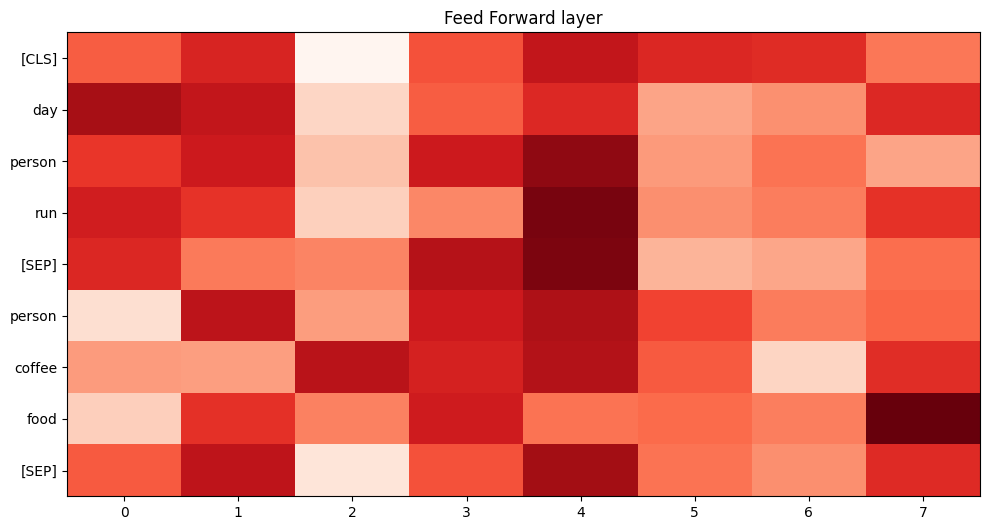

In [22]:
titles = ['Embbeding layer', 'Attention layer', 'Feed Forward layer']
token_journey([
    input_embeddings.squeeze(0), 
    attention_output.squeeze(0), 
    layer_output.squeeze(0)], token_ids=[int(x) for x in input_ids[0]], 
    titles=titles, sleep_time=2)

## 7. Stack BERT layers in a full architecture

In [23]:
config['num_hidden_layers'] = 2

In [24]:
class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer = nn.ModuleList([
            BertLayer(config) for _ in range(config["num_hidden_layers"])
        ])

    def forward(self, hidden_states, output_all_layers=True):
        all_hidden_states = ()
        all_attentions = ()
        
        for layer_module in self.layer:
            if output_all_layers:
                all_hidden_states = all_hidden_states + (hidden_states,)
            hidden_states, attention_probs = layer_module(hidden_states)
            if output_all_layers:
                all_attentions = all_attentions + (attention_probs,)
        if output_all_layers:
            all_hidden_states = all_hidden_states + (hidden_states,)
        return all_hidden_states, all_attentions

**Pooling the `[CLS]` token**

The `[CLS]` token is where BERT is supposed to store the information about the whole sequence. That's why we need a facility to pool it out.

In [25]:
class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config["hidden_size"], config["hidden_size"])
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We just grab the vector for the *first token* ([CLS])
        first_token_tensor = hidden_states[:, 0]
        # Pass it through the dense layer and activation
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

**The final BERT model**

In [26]:
class BertModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)

    def forward(self, input_ids, token_type_ids):
        embedding_output = self.embeddings(input_ids, token_type_ids)
        all_hidden_states, all_attentions = self.encoder(embedding_output)
        sequence_output = all_hidden_states[-1]
        pooled_output = self.pooler(sequence_output)
        # We return the last layer's vectors and the [CLS] vector
        # Just for demo purposes, we get also all the attentions
        # (We can add all_hidden_states/all_attentions later if needed)
        return sequence_output, pooled_output, all_attentions

In [27]:
tiny_bert_model = BertModel(config)
tiny_bert_model.eval()

with torch.no_grad():
    sequence_output, pooled_output, attentions = tiny_bert_model(input_ids, token_type_ids)

print("--- Output from full BertModel ---")
print(f"Final Sequence Output shape: {sequence_output.shape}")
print(f"Final Pooled Output shape:   {pooled_output.shape}")

print("\n--- Pooled Output Vector ([CLS] token) ---")
print(pooled_output)

--- Output from full BertModel ---
Final Sequence Output shape: torch.Size([1, 9, 8])
Final Pooled Output shape:   torch.Size([1, 8])

--- Pooled Output Vector ([CLS] token) ---
tensor([[ 0.3760, -0.3195,  0.7580, -0.1710,  0.3648, -0.7346,  0.1168, -0.7950]])


## 8. Pre-Training

This model will take our input_ids and token_type_ids and, in one pass, output the two predictions we need:

- **For the MLM Task**: What's the original word for [MASK]?
- **For the NSP Task**: Are these two sentences related?

### NSP Head
It's just a simple linear classifier that takes the `[CLS]` token's vector and predicts one of two classes (`IsNext` or `NotNext`).

- Input: pooled_output [batch, 8]
- Output: nsp_logits [batch, 2]

### MLM Head
- Input: sequence_output [batch, seq, 8]
- Output: mlm_logits [batch, seq, vocab_size]

This head has to project our 8-dimensional token vectors into 14-dimensional "scores" (logits) for every word in our vocabulary. It does this in two sub-steps:
1. **Transform**: It passes the vectors through another FFN (Dense -> GELU -> LayerNorm) to "prepare" them for prediction.
2. **Decode**: It uses a final linear layer to map hidden_size (8) to vocab_size (14).

The "decoder" matrix that maps 8 $\rightarrow$ 14 has the exact same shape as our token embedding matrix (Module 1) that maps 14 $\rightarrow$ 8. BERT ties these weights. The `word_embeddings.weight` matrix is re-used (in its transposed form) as the "decoder" matrix. This saves a ton of parameters and makes logical sense: the same "lookup table" used to turn a token ID into a vector should be used to turn a vector back into a token ID.

In [28]:
class BertPredictionHeadTransform(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config["hidden_size"], config["hidden_size"])
        if config["hidden_act"] == "gelu":
            self.transform_act_fn = nn.GELU()
        else:
            self.transform_act_fn = nn.ReLU()
        self.LayerNorm = nn.LayerNorm(config["hidden_size"], eps=1e-5)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states

In [29]:
class BertLMPredictionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.transform = BertPredictionHeadTransform(config)
        # The "decoder" layer that maps 8 -> 14
        # Note: We set bias=False because we'll add it manually.
        self.decoder = nn.Linear(config["hidden_size"], config["vocab_size"], bias=False)
        
        # We add the bias as a separate parameter
        self.bias = nn.Parameter(torch.zeros(config["vocab_size"]))
        
        # Manually set the decoder's bias to our new parameter
        self.decoder.bias = self.bias

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states)
        return hidden_states

In [30]:
class BertForPreTraining(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BertModel(config)
        self.mlm_head = BertLMPredictionHead(config)
        self.nsp_classifier = nn.Linear(config["hidden_size"], 2)
        self.tie_weights()

    def tie_weights(self):
        """
        Tie the weights between the token embeddings and the MLM decoder.
        This is a *critical* part of the BERT design.
        """
        # Get the weight matrix from our embedding layer (Module 1)
        embedding_weights = self.bert.embeddings.word_embeddings.weight
        
        # Set the MLM decoder's weight to be the *same* matrix
        self.mlm_head.decoder.weight = embedding_weights
        
        # And make sure the bias is still our learned 'self.mlm_head.bias'
        self.mlm_head.decoder.bias = self.mlm_head.bias

    def forward(self, input_ids, token_type_ids):
        sequence_output, pooled_output, attentions = self.bert(input_ids, token_type_ids)
        mlm_logits = self.mlm_head(sequence_output)
        nsp_logits = self.nsp_classifier(pooled_output)
        return mlm_logits, nsp_logits, attentions 

**Run the model**

In [31]:
final_model = BertForPreTraining(config)
final_model.eval()

print("--- Checking Weight Tying ---")
# Get memory addresses
emb_weights_ptr = final_model.bert.embeddings.word_embeddings.weight.data_ptr()
dec_weights_ptr = final_model.mlm_head.decoder.weight.data_ptr()

print(f"Embedding Weight Pointer: {emb_weights_ptr}")
print(f"Decoder Weight Pointer:   {dec_weights_ptr}")
print(f"Weights are tied:         {emb_weights_ptr == dec_weights_ptr}")

with torch.no_grad():
    mlm_logits, nsp_logits, attentions = final_model(input_ids, token_type_ids)

print("\n--- Final Logit Output Shapes ---")
print(f"MLM Logits shape: {mlm_logits.shape}")
print(f"NSP Logits shape: {nsp_logits.shape}")

print("\n--- MLM Logits (for token 1) ---")
# The scores for the 14 vocab words for the 2nd token ('☀️')
print(mlm_logits[0, 1, :])

print("\n--- NSP Logits ([CLS] token) ---")
# The scores for 'IsNext' and 'NotNext'
print(nsp_logits[0, :])

--- Checking Weight Tying ---
Embedding Weight Pointer: 4483093184
Decoder Weight Pointer:   4483093184
Weights are tied:         True

--- Final Logit Output Shapes ---
MLM Logits shape: torch.Size([1, 9, 14])
NSP Logits shape: torch.Size([1, 2])

--- MLM Logits (for token 1) ---
tensor([ 0.0000, -0.9099,  3.9013, -2.6731, -0.6711, -2.5851,  0.3689, -0.8983,
        -4.0181,  2.0085, -1.8275, -0.8912, -1.2588, -5.4646])

--- NSP Logits ([CLS] token) ---
tensor([-0.4559,  0.4280])


## 9. Training set and masking
This module will be a custom Dataset class that:

1. Picks two sentences, 50/50 IsNext or NotNext.
2. Performs the 15% `[MASK]` / `[RANDOM]` / `[SAME]` logic.
3. Pads all sequences to a fixed length (max_len = 16).

### The attention mask
Since our sequences are different lengths (e.g., 7 tokens vs. 9 tokens), we have to pad them all to 16 with `[PAD]` tokens to stack them in a batch.

But we can't let the model pay attention to these `[PAD]` tokens.

So, we must generate a fourth item: an attention_mask. This is a tensor of 1s and 0s that tells the model:

- 1: "Pay attention to this token."
- 0: "Ignore this token (it's padding)."

Our new dataset class will be responsible for creating all five inputs for our final model:
1. input_ids (masked)
2. token_type_ids (segments)
3. attention_mask (for padding)
4. mlm_labels (the "answers" for the masked tokens)
5. nsp_label (the "answer" for the [CLS] token)

In [32]:
import random
from torch.utils.data import Dataset, DataLoader

In [61]:
MAX_LEN = 16

EMOJI_CORPUS = [
    # Doc 1: "The Productive Morning" (Our old Doc 1)
    [
        "☀️ 🧑 🏃", 
        "🧑 ☕ 🥐", 
        "🧑 💻"
    ],
    
    # Doc 2: "The Standard Evening" (Our old Doc 2)
    [
        "🌙 🧑 📖", 
        "🧑 😴"
    ],
    
    # Doc 3: "The Coder's Morning"
    [
        "☀️ 🧑 ☕ 💻",    # Starts with coffee and code
        "🧑 💻",
        "🧑 ☕ 💻",    # More coffee, more code
        "🧑 🥐",          # Quick snack
        "🧑 💻"
    ],

    # Doc 4: "The Athlete's Day"
    [
        "☀️ 🧑 🏃",
        "🧑 ☕",
        "🧑 💻",
        "🌙 🧑 🏃",    # A run in the evening, too!
        "🧑 😴"
    ],
    
    # Doc 5: "The Intense Study Day"
    [
        "☀️ 🧑 📖",    # Starts by reading
        "🧑 ☕ 🥐",
        "🧑 💻 📖",    # Works AND reads
        "🌙 🧑 📖",
        "🧑 😴"
    ],
    
    # Doc 6: "The (Almost) Relaxing Day"
    [
        "☀️ 🧑 😴",    # Slept in late
        "🧑 🥐 ☕",
        "🧑 📖",
        "🌙 🧑 ☕ 📖",  # Evening coffee and a book
        "🧑 😴"
    ]
]


EMOJI_TOKENS = [
    token for token, idx in TOKEN_TO_ID.items() 
    if idx > 4 # Skip [PAD], [UNK], [CLS], [SEP], [MASK]
]

print("Readable translation")
for doc in EMOJI_CORPUS:
    s1 = " ".join(TOKEN_TO_TEXT[x] for x in doc[0].split())
    s2 = " ".join(TOKEN_TO_TEXT[x] for x in doc[1].split())
    print(f"{s1} => {s2}")

Readable translation
day person run => person coffee food
night person book => person sleep
day person coffee work => person work
day person run => person coffee
day person book => person coffee food
day person sleep => person food coffee


In [62]:
class BertPretrainingDataset(Dataset):
    """
    This dataset class generates masked token sequences and NSP pairs
    on-the-fly for BERT pre-training.
    """
    def __init__(self, corpus, vocab_map, max_len):
        self.corpus = corpus
        self.vocab_map = vocab_map
        self.max_len = max_len
        self.vocab_keys = list(vocab_map.keys())
        self.special_tokens = {
            self.vocab_map['[PAD]'], self.vocab_map['[UNK]'],
            self.vocab_map['[CLS]'], self.vocab_map['[SEP]'],
            self.vocab_map['[MASK]']
        }
        self.emoji_token_ids = [vocab_map[t] for t in EMOJI_TOKENS]

    def __len__(self):
        # For a demo, we can just define a "virtual" length.
        # Each "epoch" will just be 1000 random samples.
        return 1000 

    def __getitem__(self, index):
        # `index` is ignored; we just generate a random sample every time.
        
        # --- 1. Next Sentence Prediction (NSP) Task ---
        if random.random() < 0.5:
            # 50% chance: Get a TRUE "IsNext" pair
            sent_a_str, sent_b_str = self._get_next_sentence_pair()
            nsp_label = 0 # 0 = IsNext
        else:
            # 50% chance: Get a FALSE "NotNext" pair
            sent_a_str, sent_b_str = self._get_random_sentence_pair()
            nsp_label = 1 # 1 = NotNext
            
        tokens_a = [self.vocab_map.get(t, self.vocab_map['[UNK]']) for t in sent_a_str.split(' ')]
        tokens_b = [self.vocab_map.get(t, self.vocab_map['[UNK]']) for t in sent_b_str.split(' ')]
        
        combined_tokens = [self.vocab_map['[CLS]']] + tokens_a + \
                          [self.vocab_map['[SEP]']] + tokens_b + \
                          [self.vocab_map['[SEP]']]
        
        segment_ids = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
        
        masked_tokens, mlm_labels = self._mask_tokens(combined_tokens)
        
        # Padding
        padding_len = self.max_len - len(masked_tokens)
        input_ids = masked_tokens + [self.vocab_map['[PAD]']] * padding_len
        
        token_type_ids = segment_ids + [0] * padding_len
        
        # Pad MLM labels with -100 (PyTorch's CrossEntropyLoss default ignore_index)
        mlm_labels = mlm_labels + [-100] * padding_len
        # Pad attention mask with 0s
        attention_mask = ([1] * len(masked_tokens)) + ([0] * padding_len)
        
        input_ids = torch.tensor(input_ids[:self.max_len])
        token_type_ids = torch.tensor(token_type_ids[:self.max_len])
        attention_mask = torch.tensor(attention_mask[:self.max_len])
        mlm_labels = torch.tensor(mlm_labels[:self.max_len])
        nsp_label = torch.tensor(nsp_label) # This is a single value

        return {
            "input_ids": input_ids,
            "token_type_ids": token_type_ids,
            "attention_mask": attention_mask,
            "mlm_labels": mlm_labels,
            "nsp_label": nsp_label
        }
    
    def _mask_tokens(self, tokens):
        """
        Applies the 15% masking procedure.
        80% -> [MASK]
        10% -> [RANDOM]
        10% -> [SAME]
        """
        masked_tokens = list(tokens) # Make a copy
        
        # The "answer key". -100 means "no prediction needed"
        mlm_labels = [-100] * len(tokens)
        
        for i, token_id in enumerate(tokens):
            # We only mask our "emoji" tokens, not [CLS], [SEP], etc.
            if token_id in self.special_tokens:
                continue
                
            # 15% chance to mask this token
            if random.random() < 0.15:
                # This is a token we need to predict.
                # The "answer" is the original token ID.
                mlm_labels[i] = token_id
                
                rand = random.random()
                if rand < 0.8:
                    # 80% chance: Replace with [MASK]
                    masked_tokens[i] = self.vocab_map['[MASK]']
                elif rand < 0.9:
                    # 10% chance: Replace with a random emoji
                    masked_tokens[i] = random.choice(self.emoji_token_ids)
                else:
                    # 10% chance: Leave it as-is (the "same" token)
                    pass # `masked_tokens[i]` is already the correct ID
        
        return masked_tokens, mlm_labels

    def _get_next_sentence_pair(self):
        # Find a document with at least 2 sentences
        doc = random.choice(self.corpus)
        while len(doc) < 2:
            doc = random.choice(self.corpus)
        
        # Pick a random starting point
        start_index = random.randint(0, len(doc) - 2)
        return doc[start_index], doc[start_index + 1]

    def _get_random_sentence_pair(self):
        # Pick two random sentences from anywhere
        doc1 = random.choice(self.corpus)
        sent_a = random.choice(doc1)
        
        doc2 = random.choice(self.corpus)
        sent_b = random.choice(doc2)
        
        # Make sure they're not *actually* a next-sentence pair
        if (sent_a == sent_b) or (sent_a in doc1 and doc1.index(sent_a) < len(doc1) - 1 and doc1[doc1.index(sent_a) + 1] == sent_b):
             # This is too complex, let's just re-roll. This is lazy but fine for a demo.
             return self._get_random_sentence_pair()
            
        return sent_a, sent_b

**Demo**

In [63]:
dataset = BertPretrainingDataset(EMOJI_CORPUS, TOKEN_TO_ID, MAX_LEN)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

batch = next(iter(dataloader))

print("--- One Batch from our DataLoader ---")
print(f"Batch keys: {batch.keys()}")

print("\n--- input_ids (Masked) ---")
print(batch["input_ids"].shape)
print(batch["input_ids"])

print("\n--- attention_mask (Padding) ---")
print(batch["attention_mask"].shape)
print(batch["attention_mask"])

print("\n--- mlm_labels (The 'Answers') ---")
print(batch["mlm_labels"].shape)
print(batch["mlm_labels"])

print("\n--- nsp_label (IsNext/NotNext) ---")
print(batch["nsp_label"].shape)
print(batch["nsp_label"])

--- One Batch from our DataLoader ---
Batch keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'mlm_labels', 'nsp_label'])

--- input_ids (Masked) ---
torch.Size([4, 16])
tensor([[ 2,  7, 10,  3,  5,  7,  4,  3,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  5,  7, 11,  3,  7,  8,  4,  3,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  7,  4,  3,  5,  7, 13,  3,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  6,  4, 12,  3,  7, 13,  3,  0,  0,  0,  0,  0,  0,  0,  0]])

--- attention_mask (Padding) ---
torch.Size([4, 16])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

--- mlm_labels (The 'Answers') ---
torch.Size([4, 16])
tensor([[-100, -100, -100, -100, -100, -100,   13, -100, -100, -100, -100, -100,
         -100, -100, -100, -100],
        [-100, -100, -100, -100, -100, -100, -100,    9, -1

### Masking Attention for padding
The core idea is to modify the attention scores before the softmax.

**Original Scores**: attention_scores = Q @ K.T

**Masking Logic**: We will create a mask that has 0 for real tokens and a very large negative number (like -1e9) for [PAD] tokens.

**New Scores**: attention_scores = (Q @ K.T) + attention_mask

**Result**: softmax(scores + -1e9) becomes 0. This forces the model to have zero attention on padding.

In [64]:
class SelfAttention(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.num_attention_heads = config['attention_heads']
        self.dropout_prob = config['attention_dropout_prob']
        self.hidden_size = config['hidden_size']

        if self.hidden_size % self.num_attention_heads != 0:
            raise ValueError("The hidden size is not a multiple of the number of attention heads")

        self.attention_head_size = int(self.hidden_size / self.num_attention_heads)
        
        # In a multi-head setup, all_head_size would be (num_heads * head_size).
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        
        # --- The 3 Linear Layers ---
        # These project the input embeddings (d_model=8) into Q, K, and V.
        self.Q = nn.Linear(self.hidden_size, self.all_head_size)
        self.K = nn.Linear(self.hidden_size, self.all_head_size)
        self.V = nn.Linear(self.hidden_size, self.all_head_size)
        
        self.dropout = nn.Dropout(self.dropout_prob)

    def forward(self, hidden_states, attention_mask):
        Q = self.Q(hidden_states)
        K = self.K(hidden_states)
        V = self.V(hidden_states)
        
        Q = Q.view(Q.size(0), Q.size(1), self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        K = K.view(K.size(0), K.size(1), self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        V = V.view(V.size(0), V.size(1), self.num_attention_heads, self.attention_head_size).transpose(1, 2)

        attention_scores = torch.matmul(Q, K.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        
        # Add the mask *before* the softmax.
        attention_scores = attention_scores + attention_mask

        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs)
        
        context_layer = torch.matmul(attention_probs, V)
        
        context_layer = context_layer.transpose(1, 2).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)
        
        return context_layer, attention_probs

**Wrappers to pass the attention mask**

In [65]:
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention_module = SelfAttention(config)
        self.dense = nn.Linear(config["hidden_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, hidden_states, attention_mask):
        context_vectors, attention_probs = self.attention_module(hidden_states, attention_mask)
        attention_output = self.dense(context_vectors)
        attention_output = self.dropout(attention_output)
        return attention_output, attention_probs

class BertAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attention = BertSelfAttention(config)
        self.LayerNorm = nn.LayerNorm(config["hidden_size"], eps=1e-5)

    def forward(self, hidden_states, attention_mask):
        attention_output, attention_probs = self.self_attention(
            hidden_states, attention_mask)
        # The "Add & Norm" step:
        # 1. Add the residual (skip) connection
        # 2. Apply Layer Normalization
        # hidden_states is the *original input* to this block
        summed_output = attention_output + hidden_states
        normed_output = self.LayerNorm(summed_output)
        return normed_output, attention_probs

class BertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, attention_mask, return_attention_output=False):
        """
        Args:
            hidden_states (torch.Tensor): (batch, seq_len, 8)
        
        Returns:
            layer_output (torch.Tensor): (batch, seq_len, 8)
            attention_probs (torch.Tensor): (batch, 1, seq_len, seq_len)
        """
        
        attention_output, attention_probs = self.attention(
            hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        if return_attention_output:
            return layer_output, attention_probs, attention_output
        else:
            return layer_output, attention_probs

class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer = nn.ModuleList([
            BertLayer(config) for _ in range(config["num_hidden_layers"])
        ])

    def forward(self, hidden_states, attention_mask, output_all_layers=True):
        all_hidden_states = ()
        all_attentions = ()
        
        for layer_module in self.layer:
            if output_all_layers:
                all_hidden_states = all_hidden_states + (hidden_states,)
            hidden_states, attention_probs = layer_module(hidden_states, attention_mask)
            if output_all_layers:
                all_attentions = all_attentions + (attention_probs,)
        if output_all_layers:
            all_hidden_states = all_hidden_states + (hidden_states,)
        return all_hidden_states, all_attentions

**BertModel**

In [66]:
class BertModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)

    def forward(self, input_ids, token_type_ids, attention_mask):
        embedding_output = self.embeddings(input_ids, token_type_ids)
        # We need to "extend" the 2D mask to 4D for the attention layers.
        # input attention_mask: (batch_size, seq_len)  e.g., [1, 1, 1, 0, 0]
        # 1. Add a head dimension: (batch_size, 1, seq_len)
        extended_attention_mask = attention_mask.unsqueeze(1)
        # 2. Add a query dimension: (batch_size, 1, 1, seq_len)
        extended_attention_mask = extended_attention_mask.unsqueeze(2)

        inverted_mask = 1.0 - extended_attention_mask.to(embedding_output.dtype)
        extended_attention_mask = inverted_mask * -10000.0
        
        all_hidden_states, all_attentions = self.encoder(
            embedding_output, attention_mask=extended_attention_mask)
        
        sequence_output = all_hidden_states[-1]
        pooled_output = self.pooler(sequence_output)
        # We return the last layer's vectors and the [CLS] vector
        # Just for demo purposes, we get also all the attentions
        # (We can add all_hidden_states/all_attentions later if needed)
        return sequence_output, pooled_output, all_attentions

class BertForPreTraining(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BertModel(config)
        self.mlm_head = BertLMPredictionHead(config)
        self.nsp_classifier = nn.Linear(config["hidden_size"], 2)
        self.tie_weights()

    def tie_weights(self):
        """
        Tie the weights between the token embeddings and the MLM decoder.
        This is a *critical* part of the BERT design.
        """
        # Get the weight matrix from our embedding layer (Module 1)
        embedding_weights = self.bert.embeddings.word_embeddings.weight
        
        # Set the MLM decoder's weight to be the *same* matrix
        self.mlm_head.decoder.weight = embedding_weights
        
        # And make sure the bias is still our learned 'self.mlm_head.bias'
        self.mlm_head.decoder.bias = self.mlm_head.bias

    def forward(self, input_ids, token_type_ids, attention_mask):
        sequence_output, pooled_output, attentions = self.bert(
            input_ids, token_type_ids, attention_mask)
        mlm_logits = self.mlm_head(sequence_output)
        nsp_logits = self.nsp_classifier(pooled_output)
        return mlm_logits, nsp_logits, attentions 

**Demo**

In [67]:
final_model = BertForPreTraining(config)
final_model.eval()

batch = next(iter(dataloader))

input_ids      = batch["input_ids"]
token_type_ids = batch["token_type_ids"]
attention_mask = batch["attention_mask"]
mlm_labels     = batch["mlm_labels"]
nsp_label      = batch["nsp_label"]

print("--- Running Patched Model ---")
print(f"Input IDs shape:      {input_ids.shape}")
print(f"Token Type IDs shape: {token_type_ids.shape}")
print(f"Attention Mask shape: {attention_mask.shape}")

with torch.no_grad():
    mlm_logits, nsp_logits, attentions = final_model(
        input_ids, 
        token_type_ids, 
        attention_mask
    )

print("\n--- Success! ---")
print(f"Output MLM Logits shape: {mlm_logits.shape}")
print(f"Output NSP Logits shape: {nsp_logits.shape}")

--- Running Patched Model ---
Input IDs shape:      torch.Size([4, 16])
Token Type IDs shape: torch.Size([4, 16])
Attention Mask shape: torch.Size([4, 16])

--- Success! ---
Output MLM Logits shape: torch.Size([4, 16, 14])
Output NSP Logits shape: torch.Size([4, 2])


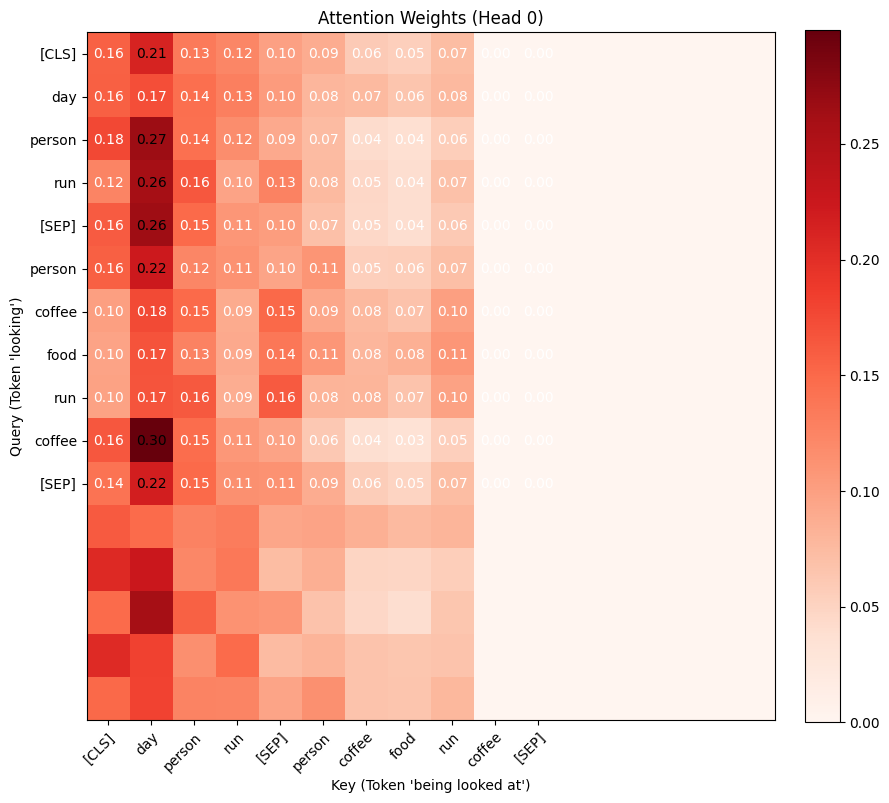

In [68]:
plot_attention_heatmap(attention_matrix=attentions[-1], token_ids=token_ids)

## 10. Training Loop

Setting up model and dataloader...
Starting training...
Step 050/5000 | Total Loss: 6.4102 (MLM: 5.6946, NSP: 0.7156)
Step 100/5000 | Total Loss: 4.9464 (MLM: 4.0903, NSP: 0.8561)
Step 150/5000 | Total Loss: 3.5529 (MLM: 2.8323, NSP: 0.7205)
Step 200/5000 | Total Loss: 4.2216 (MLM: 3.5241, NSP: 0.6975)
Step 250/5000 | Total Loss: 7.5902 (MLM: 6.8931, NSP: 0.6971)

--- Training Complete ---


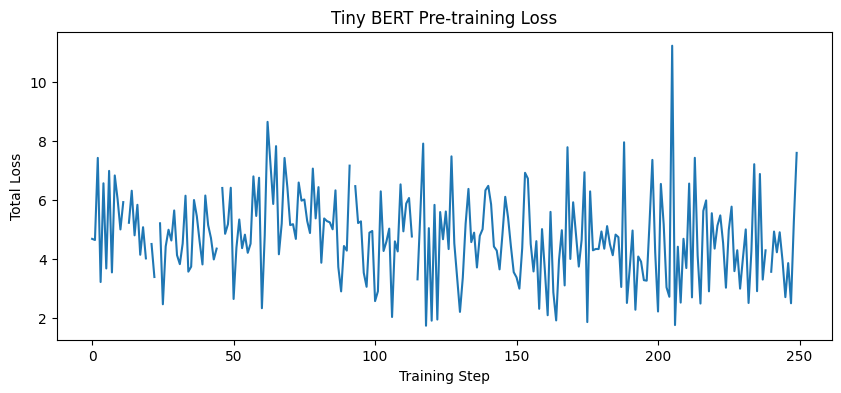

In [69]:
print("Setting up model and dataloader...")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

model = BertForPreTraining(config)

dataset = BertPretrainingDataset(EMOJI_CORPUS, TOKEN_TO_ID, MAX_LEN)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# For NSP: A simple classifier (logits: [batch, 2], labels: [batch])
nsp_loss_fn = nn.CrossEntropyLoss()

# For MLM:
mlm_loss_fn = nn.CrossEntropyLoss(ignore_index=-100) 

LEARNING_RATE = 1e-4
WARMUP_STEPS = 10

def lr_lambda(current_step):
    """Linear warmup function"""
    if current_step < WARMUP_STEPS:
        # Increase LR linearly from 0 to 1.0
        return float(current_step) / float(max(1, WARMUP_STEPS))
    # After warmup, LR is constant (1.0 * LEARNING_RATE)
    return 1.0

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, eps=1e-6)

print("Starting training...")
model.train() # Put the model in "training" mode (enables dropout, etc.)

num_train_steps = 5000
loss_history = []

for i, batch in enumerate(dataloader):
    # Stop the loop
    if i >= num_train_steps:
        break
        
    input_ids      = batch["input_ids"]
    token_type_ids = batch["token_type_ids"]
    attention_mask = batch["attention_mask"]
    mlm_labels     = batch["mlm_labels"]
    nsp_label      = batch["nsp_label"]

    optimizer.zero_grad()

    mlm_logits, nsp_logits, attentions = model(input_ids, token_type_ids, attention_mask)
    
    # Calculate the two losses
    loss_mlm = mlm_loss_fn(
        mlm_logits.view(-1, config["vocab_size"]), # (4*16, 14)
        mlm_labels.view(-1)                        # (4*16)
    )
    
    loss_nsp = nsp_loss_fn(
        nsp_logits, # (4, 2)
        nsp_label   # (4)
    )
    
    # The final loss is just the sum of the two!
    total_loss = loss_mlm + loss_nsp
    
    total_loss.backward()
    
    # Clipping gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
    optimizer.step()
    
    loss_history.append(total_loss.item())
    if (i + 1) % 50 == 0:
        print(f"Step {i+1:03d}/{num_train_steps} | Total Loss: {total_loss.item():.4f} (MLM: {loss_mlm.item():.4f}, NSP: {loss_nsp.item():.4f})")

print("\n--- Training Complete ---")

# --- 5. Plot the Loss ---
plt.figure(figsize=(10, 4))
plt.plot(loss_history)
plt.title("Tiny BERT Pre-training Loss")
plt.xlabel("Training Step")
plt.ylabel("Total Loss")
plt.show()

## TEST

### Masked Lanigage Model

In [70]:
def predict_mask(sentence_with_mask, model):
    """
    Funzione per testare la predizione MLM su una singola frase.
    """
    # 1. Metti il modello in modalità valutazione
    model.eval()

    # 2. Prepara gli input
    token_list = sentence_with_mask.split(' ')
    mask_index = -1
    try:
        mask_index = token_list.index('[MASK]')
    except ValueError:
        print("Errore: La frase non contiene un token [MASK].")
        return

    token_id_list = tokenize(sentence_with_mask, TOKEN_TO_ID)
    seq_len = len(token_id_list)
    
    # 3. Padding (come nel DataLoader)
    padding_len = MAX_LEN - seq_len
    
    input_ids = torch.tensor([token_id_list + [TOKEN_TO_ID['[PAD]']] * padding_len])
    
    # Per un test MLM su una singola frase, i segment IDs sono tutti 0
    token_type_ids = torch.tensor([[0] * MAX_LEN])
    
    attention_mask = torch.tensor([[1] * seq_len + [0] * padding_len])

    # 4. Esegui il modello
    with torch.no_grad():
        # Eseguiamo il modello completo per ottenere i logits
        mlm_logits, _, attentions = model(input_ids, token_type_ids, attention_mask)
    
    mask_logits = mlm_logits[0, mask_index, :] # Shape: (14)
        
    return mask_logits, attentions


In [71]:
test_sentence = "[CLS] [MASK] ☕ 🥐 [SEP]"
logits, attentions = predict_mask(test_sentence, model)

In [72]:
import pandas as pd

In [73]:
candidates = pd.Series(logits, index=TOKEN_TO_ID.keys())

In [74]:
candidates.sort_values(ascending=False)

[MASK]    4.832131
🧑         4.491603
🌙         4.287043
🥐         2.693103
☀️        2.501346
📖         2.052194
😴         1.590931
💻        -0.061160
[PAD]    -0.124667
[SEP]    -0.704719
[CLS]    -1.648348
☕        -1.780904
🏃        -2.755821
[UNK]    -4.020637
dtype: float32

### Document encoding

In [75]:
from sklearn.manifold import TSNE

Extract [CLS] from corpus...
25 vectors, each of dimension 8.


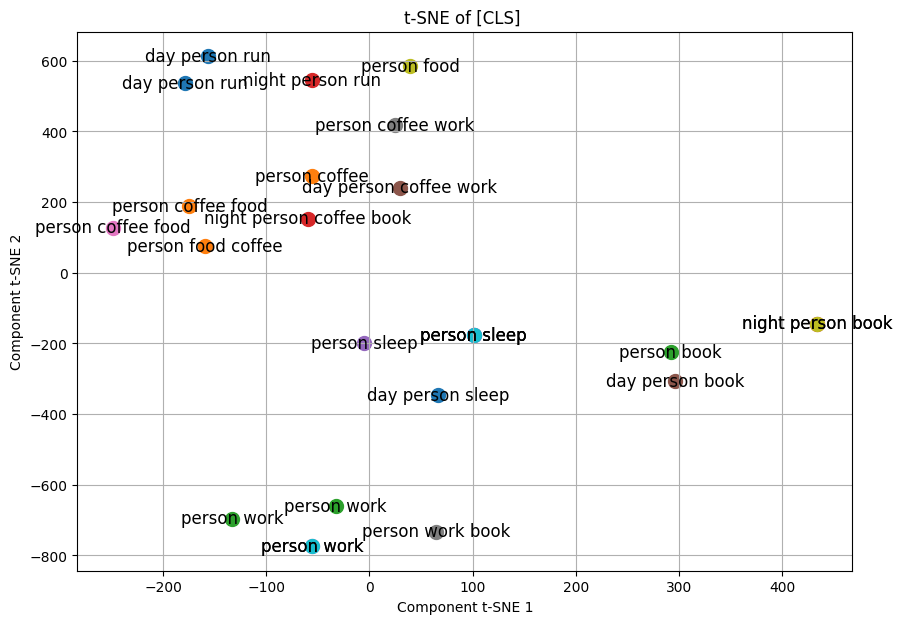

In [76]:
def get_cls_vectors(model, corpus):
    model.eval()
    
    sentence_strings = []
    cls_vectors = []
    
    for doc in corpus:
        for sentence in doc:
            sentence_strings.append(" ".join([TOKEN_TO_TEXT[x] for x in sentence.split()]))
            
            input_string = f"[CLS] {sentence} [SEP]"
            token_id_list = tokenize(input_string, TOKEN_TO_ID)
            seq_len = len(token_id_list)
            
            padding_len = MAX_LEN - seq_len
            input_ids = torch.tensor([token_id_list + [TOKEN_TO_ID['[PAD]']] * padding_len])
            token_type_ids = torch.tensor([[0] * MAX_LEN])
            attention_mask = torch.tensor([[1] * seq_len + [0] * padding_len])
            
            with torch.no_grad():
                # !!! IMPORTANT !!!
                # Use 'model.bert', not 'model'.
                # We want 'pooled_output' before it being a logit NSP.
                _, pooled_output, _ = model.bert(input_ids, token_type_ids, attention_mask)
                
                cls_vectors.append(pooled_output.squeeze().numpy())
                
    return sentence_strings, np.array(cls_vectors)

print("Extract [CLS] from corpus...")
labels, vectors = get_cls_vectors(model, EMOJI_CORPUS)

print(f"{len(vectors)} vectors, each of dimension {vectors.shape[1]}.")

n_samples = len(vectors)
perplexity_value = min(max(1, n_samples - 1), 5)

tsne = TSNE(
    n_components=2, 
    perplexity=perplexity_value, 
    init='pca', 
    learning_rate='auto',
    random_state=42
)
reduced_points = tsne.fit_transform(vectors)

plt.figure(figsize=(10, 7))
plt.title("t-SNE of [CLS] ")
plt.xlabel("Component t-SNE 1")
plt.ylabel("Component t-SNE 2")

for i, label in enumerate(labels):
    x, y = reduced_points[i]
    plt.scatter(x, y, s=100)
    
    plt.annotate(label, (x, y), ha='center', va='center', fontsize=12)

plt.grid(True)
plt.show()